In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [9]:
df = pd.read_csv('../../data/steel_industry_data.csv')


In [11]:
series = df[['date', 'Usage_kWh']].copy()
series['date'] = pd.to_datetime(series['date'], dayfirst=True)
series.set_index('date', inplace=True)


In [12]:
train_size = int(len(series) * 0.8)

train = series.iloc[:train_size]
test  = series.iloc[train_size:]


In [13]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)


In [14]:
WINDOW_SIZE = 96  # 24h bei 15 Minuten

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test   = create_sequences(test_scaled, WINDOW_SIZE)


In [15]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0159 - val_loss: 0.0074
Epoch 2/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 3/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 4/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 5/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 6/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 7/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 8/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 9/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 10/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 11/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 12/30
393/393 ━━━━━━━━━━

In [17]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [18]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae  = mean_absolute_error(y_test_inv, y_pred)
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100

print(f"RMSE: {rmse:.4f} kWh")
print(f"MAE:  {mae:.4f} kWh")
print(f"MAPE: {mape:.2f} %")


RMSE: 8.9567 kWh
MAE:  4.5131 kWh
MAPE: inf %


C:\Users\benja\AppData\Local\Temp\ipykernel_27268\3928774796.py:3: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100


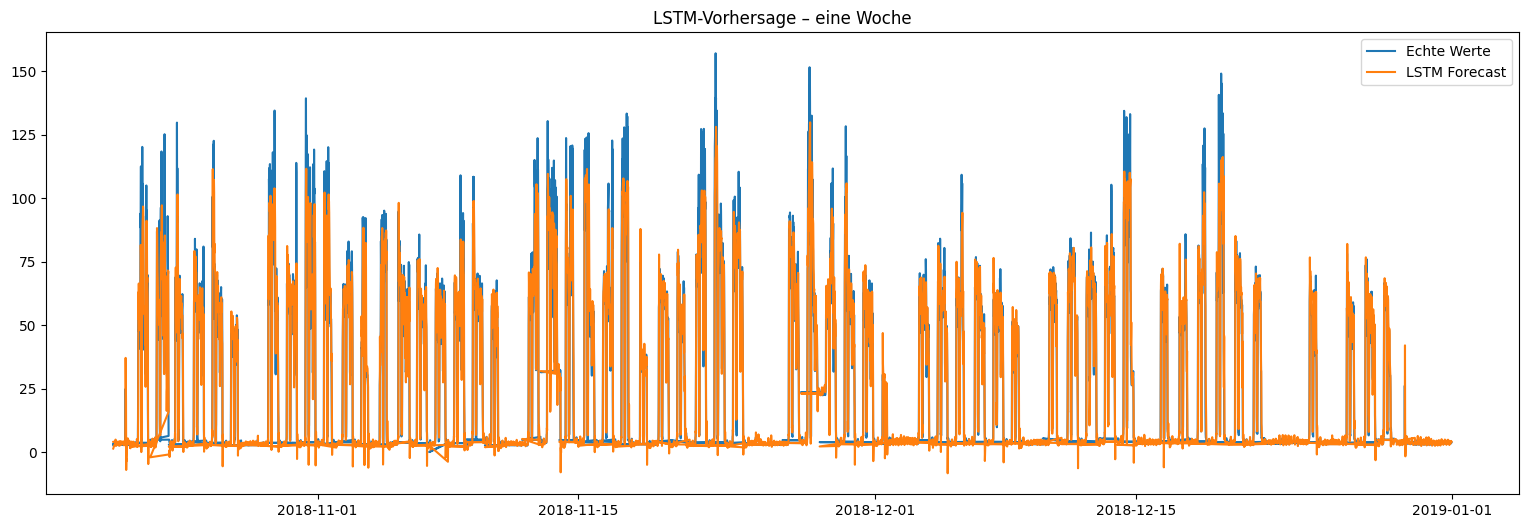

In [ ]:
WEEK_STEPS = 7 * 24 * 4

dates_test = test.index[WINDOW_SIZE:]

plt.figure(figsize=(19,6))
plt.plot(dates_test, y_test_inv, label='Echte Werte')
plt.plot(dates_test, y_pred, label='LSTM Forecast')
plt.title('LSTM-Vorhersage – eine Woche')
plt.legend()
plt.show()


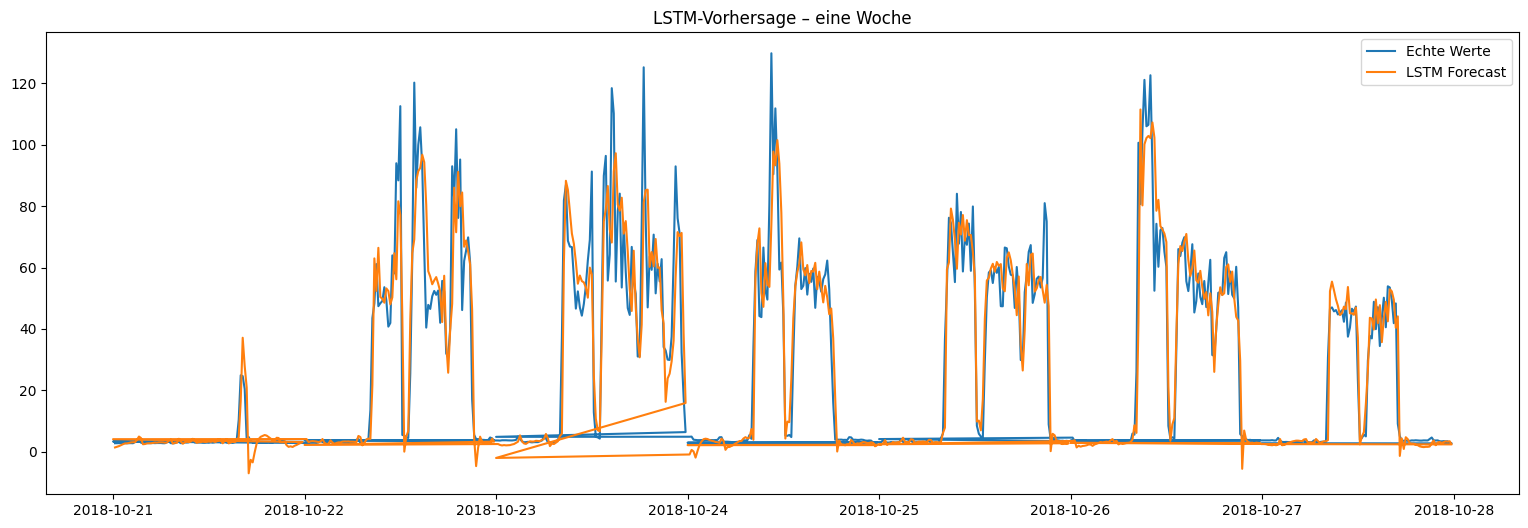

In [22]:
WEEK_STEPS = 7 * 24 * 4

dates_test = test.index[WINDOW_SIZE:]

plt.figure(figsize=(19,6))
plt.plot(dates_test[:WEEK_STEPS], y_test_inv[:WEEK_STEPS], label='Echte Werte')
plt.plot(dates_test[:WEEK_STEPS], y_pred[:WEEK_STEPS], label='LSTM Forecast')
plt.title('LSTM-Vorhersage – eine Woche')
plt.legend()
plt.show()
